# COMP S493F Lab 9

In [ ]:
%env TF_CPP_MIN_LOG_LEVEL=2
import tensorflow as tf
tf.config.experimental.enable_op_determinism()

env: TF_CPP_MIN_LOG_LEVEL=2


In this lesson, you'll work on:

- transfer learning,
- the VGG-16 and MobileNet pre-trained models,
- using Google drive in Colab, and
- data augmentation.

### Student name: *LO TSZ KIN*

# Utility code

This section contains some utility functions for use in the rest of the lesson.

This function loads the CIFAR-10 dataset, prepares the data, and returns portion of the data in a 4-tuple: `X_train`, `y_train`, `X_test`, `y_test`. Note that this function does not scale the features (`X_train` and `X_test`), which will be preprocessed using the `preprocess_input()` function of Keras applications.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10

def load_and_prep_cifar10_no_scale_x(ratio=0.5):
    keras.utils.set_random_seed(42)
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    if ratio < 1:
        sz_train = int(len(X_train) * ratio)
        sz_test = int(len(X_test) * ratio)
        X_train, y_train = X_train[:sz_train], y_train[:sz_train]
        X_test, y_test = X_test[:sz_test], y_test[:sz_test]
    y_train_oh = keras.utils.to_categorical(y_train, 10)  # one-hot encode
    y_test_oh = keras.utils.to_categorical(y_test, 10)
    return X_train, y_train_oh, X_test, y_test_oh

This function retrieves the final results in a training history, i.e. values of "loss", "val_loss", "acc", and "val_acc" in the final epoch.

In [ ]:
def history_final_values(history):
    return {k: round(v[-1], 4) for k, v in history.history.items()}

This function plots a training history, including both training and validation results.

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(history.history["acc"], label="acc")
    plt.plot(history.history["val_acc"], label="val_acc")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

This function compiles and fits a model, and returns the training history.

In [ ]:
def compile_and_fit_model(model, X_train, y_train, X_test, y_test,
                          epochs=20, batch_size=256, verbose=2):
    model.compile(loss="categorical_crossentropy",
                  optimizer="adam", metrics=["acc"])
    history = model.fit(X_train, y_train, epochs=epochs,
                        batch_size=batch_size, verbose=verbose,
                        validation_data=(X_test, y_test))
    return history

# Transfer learning with MobileNet

Transfer learning refers to reusing pre-trained models for new different applications. It often involves incorporating a pre-trained model into your new model and training the new model for the application in question.

MobileNet is a capable CNN yet very small in size. The following model reuses the MobileNet CNN. Note the input shape of 32&times;32&times;3 specified in the `MobileNet` model creation.

In [ ]:
from tensorflow.keras.applications import mobilenet

X_train, y_train, X_test, y_test = load_and_prep_cifar10_no_scale_x()
X_train = mobilenet.preprocess_input(X_train)
X_test = mobilenet.preprocess_input(X_test)
base_model = mobilenet.MobileNet(weights="imagenet", include_top=False,
                                 input_shape=(32, 32, 3))
base_model.trainable = False
model = keras.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(1024, activation="relu"),
    layers.Dense(10, activation="softmax")
])
history = compile_and_fit_model(model, X_train, y_train, X_test, y_test,
                                epochs=10)
print(history_final_values(history))

170498071/170498071 [==============================] - 2s 0us/step


17225924/17225924 [==============================] - 0s 0us/step
Epoch 1/10
98/98 - 7s - loss: 2.1879 - acc: 0.1930 - val_loss: 2.1459 - val_acc: 0.2090 - 7s/epoch - 69ms/step
Epoch 2/10
98/98 - 1s - loss: 2.1354 - acc: 0.2172 - val_loss: 2.1283 - val_acc: 0.2172 - 1s/epoch - 14ms/step
Epoch 3/10
98/98 - 1s - loss: 2.1210 - acc: 0.2193 - val_loss: 2.1266 - val_acc: 0.2166 - 1s/epoch - 13ms/step
Epoch 4/10
98/98 - 1s - loss: 2.1127 - acc: 0.2247 - val_loss: 2.1206 - val_acc: 0.2262 - 1s/epoch - 14ms/step
Epoch 5/10
98/98 - 1s - loss: 2.1040 - acc: 0.2289 - val_loss: 2.1203 - val_acc: 0.2194 - 1s/epoch - 13ms/step
Epoch 6/10
98/98 - 1s - loss: 2.0979 - acc: 0.2297 - val_loss: 2.1172 - val_acc: 0.2240 - 1s/epoch - 14ms/step
Epoch 7/10
98/98 - 1s - loss: 2.0927 - acc: 0.2328 - val_loss: 2.1163 - val_acc: 0.2190 - 1s/epoch - 15ms/step
Epoch 8/10
98/98 - 2s - loss: 2.0881 - acc: 0.2343 - val_loss: 2.1140 - val_acc: 0.2270 - 2s/epoch - 16ms/step
Epoch 9/10
98/98 - 1s - loss: 2.0845 - acc: 0.2

The performance of this model is poor. Note the warning message in the execution output: the number of "rows", which is 32 in the model, is not one of 128, 160, 192, 224. In other words, MobileNet expects the input size to be one of these four values.

# Up-sampling and resizing images

In this section, we modify the input images to sizes that MobileNet expects to work with.

# Practice - Question 1 of 2

## Q1a

Modify the above provided MobileNet transfer learning model to up-sample the input images to 128&times;128. Specifically, make these changes:

- in the `MobileNet` creation, set the `input_shape` argument to `(128, 128, 3)` instead of `(32, 32, 3)`;
- in the `model` creation, add an up-sampling layer `layers.UpSampling2D(size=(4, 4))` as the very first layer, i.e. before `base_model`; and
- (optional) change the call to `compile_and_fit_model()` to add the argument `epochs=3` to reduce execution time.

In [ ]:
from tensorflow.keras.applications import mobilenet

X_train, y_train, X_test, y_test = load_and_prep_cifar10_no_scale_x()
X_train = mobilenet.preprocess_input(X_train)
X_test = mobilenet.preprocess_input(X_test)
base_model = mobilenet.MobileNet(weights="imagenet", include_top=False,
                                 input_shape=(128, 128, 3))# change to 128
base_model.trainable = False
model = keras.Sequential([
    layers.UpSampling2D(size=(4, 4)),  # Add up-sampling layer
    base_model,
    layers.Flatten(),
    layers.Dense(1024, activation="relu"),
    layers.Dense(10, activation="softmax")
])
history = compile_and_fit_model(model, X_train, y_train, X_test, y_test,
                                epochs=3)
print(history_final_values(history))

Epoch 1/3
98/98 - 15s - loss: 5.2795 - acc: 0.7267 - val_loss: 0.4396 - val_acc: 0.8520 - 15s/epoch - 150ms/step
Epoch 2/3
98/98 - 9s - loss: 0.2922 - acc: 0.9001 - val_loss: 0.4121 - val_acc: 0.8616 - 9s/epoch - 93ms/step
Epoch 3/3
98/98 - 10s - loss: 0.1672 - acc: 0.9488 - val_loss: 0.4033 - val_acc: 0.8614 - 10s/epoch - 105ms/step
{'loss': 0.1672, 'acc': 0.9488, 'val_loss': 0.4033, 'val_acc': 0.8614}


## Q1b

Modify the above provided MobileNet transfer learning model to up-sample the input images to 224&times;224. Specifically, make these changes:

- in the `MobileNet` creation, set the `input_shape` argument to `(224, 224, 3)` instead of `(32, 32, 3)`;
- in the `model` creation, add an up-sampling layer `layers.UpSampling2D(size=(7, 7))` as the very first layer, i.e. before `base_model`; and
- (optional) change the call to `compile_and_fit_model()` to add the argument `epochs=3` to reduce execution time.

In [ ]:
from tensorflow.keras.applications import mobilenet

X_train, y_train, X_test, y_test = load_and_prep_cifar10_no_scale_x()
X_train = mobilenet.preprocess_input(X_train)
X_test = mobilenet.preprocess_input(X_test)
base_model = mobilenet.MobileNet(weights="imagenet", include_top=False,
                                 input_shape=(224, 224, 3)) #change to 224
base_model.trainable = False
model = keras.Sequential([
    layers.UpSampling2D(size=(7, 7)),  # Add up-sampling layer
    base_model,
    layers.Flatten(),
    layers.Dense(1024, activation="relu"),
    layers.Dense(10, activation="softmax")
])
history = compile_and_fit_model(model, X_train, y_train, X_test, y_test,
                                epochs=3)  # Reduce epochs for faster execution
print(history_final_values(history))

Epoch 1/3
98/98 - 33s - loss: 11.7557 - acc: 0.6614 - val_loss: 0.5572 - val_acc: 0.8174 - 33s/epoch - 335ms/step
Epoch 2/3
98/98 - 30s - loss: 0.3058 - acc: 0.8989 - val_loss: 0.5043 - val_acc: 0.8360 - 30s/epoch - 302ms/step
Epoch 3/3
98/98 - 30s - loss: 0.1466 - acc: 0.9615 - val_loss: 0.4943 - val_acc: 0.8334 - 30s/epoch - 309ms/step
{'loss': 0.1466, 'acc': 0.9615, 'val_loss': 0.4943, 'val_acc': 0.8334}


Both models with up-sampling have good performance. Among the two, the model that up-samples input to 128&times;128 works better than the one that up-samples input to 224&times;224.

## Q1c

Up-sampling is one way to adapt the example size to the expected input size of a pre-trained model. For images, up-sampling works by repeating each pixel multiple times. Therefore, the target size must be a multiple of the original image size.

Another way to adapt the data size is resizing the images. Resizing applies interpolation and does not enforce a relation between the target size and the original size. However, interpolation demands more processing, and resizing is generally slower.

Modify the model in Q1a to use `layers.Resizing(128, 128)` as the first layer (instead of the `UpSampling2D` layer).

In [ ]:
from tensorflow.keras.applications import mobilenet

X_train, y_train, X_test, y_test = load_and_prep_cifar10_no_scale_x()
X_train = mobilenet.preprocess_input(X_train)
X_test = mobilenet.preprocess_input(X_test)
base_model = mobilenet.MobileNet(weights="imagenet", include_top=False,
                                 input_shape=(128 , 128, 3))
base_model.trainable = False
model = keras.Sequential([
    layers.Resizing(128, 128),  # change to 128
    base_model,
    layers.Flatten(),
    layers.Dense(1024, activation="relu"),
    layers.Dense(10, activation="softmax")
])
history = compile_and_fit_model(model, X_train, y_train, X_test, y_test,
                                epochs=3)  # Reduce epochs for faster execution
print(history_final_values(history))

Epoch 1/3
98/98 - 13s - loss: 2.8984 - acc: 0.7562 - val_loss: 0.4155 - val_acc: 0.8568 - 13s/epoch - 132ms/step
Epoch 2/3
98/98 - 11s - loss: 0.2477 - acc: 0.9172 - val_loss: 0.3845 - val_acc: 0.8754 - 11s/epoch - 110ms/step
Epoch 3/3
98/98 - 11s - loss: 0.1271 - acc: 0.9618 - val_loss: 0.4069 - val_acc: 0.8704 - 11s/epoch - 110ms/step
{'loss': 0.1271, 'acc': 0.9618, 'val_loss': 0.4069, 'val_acc': 0.8704}


## Q1d

Modify the model in Q1b to use `layers.Resizing(224, 224)` as the first layer (instead of the `UpSampling2D` layer).

In [ ]:
from tensorflow.keras.applications import mobilenet

X_train, y_train, X_test, y_test = load_and_prep_cifar10_no_scale_x()
X_train = mobilenet.preprocess_input(X_train)
X_test = mobilenet.preprocess_input(X_test)
base_model = mobilenet.MobileNet(weights="imagenet", include_top=False,
                                 input_shape=(224, 224, 3))
base_model.trainable = False
model = keras.Sequential([
    layers.Resizing(224, 224),  # change to 224
    base_model,
    layers.Flatten(),
    layers.Dense(1024, activation="relu"),
    layers.Dense(10, activation="softmax")
])
history = compile_and_fit_model(model, X_train, y_train, X_test, y_test,
                                epochs=3)  # Reduce epochs for faster execution
print(history_final_values(history))

Epoch 1/3
98/98 - 35s - loss: 10.9846 - acc: 0.7132 - val_loss: 0.4849 - val_acc: 0.8492 - 35s/epoch - 356ms/step
Epoch 2/3
98/98 - 31s - loss: 0.2004 - acc: 0.9331 - val_loss: 0.4069 - val_acc: 0.8726 - 31s/epoch - 313ms/step
Epoch 3/3
98/98 - 31s - loss: 0.0669 - acc: 0.9847 - val_loss: 0.3791 - val_acc: 0.8832 - 31s/epoch - 315ms/step
{'loss': 0.0669, 'acc': 0.9847, 'val_loss': 0.3791, 'val_acc': 0.8832}


## &#x2766;

Both models with resizing perform better than the models with up-sampling.

# Using Google drive and data augmentation

In this section, we connect to Google drive in a Colab notebook and try data augmentation.

Two zip files are required: `cats20.zip` and `dogs20.zip`. They contain some images from the Kaggle Cats and Dogs Dataset, <https://www.microsoft.com/en-us/download/details.aspx?id=54765>. The task is binary classification.

For execution in Colab, put the two zip files in the root directory of your Google drive. For execution in a (local) Jupyter server, put the two zip files in the same directory as the notebook file.

The following code connects to the Google drive and mounts it to the directory "/contnet/drive" of the Colab VM. The `try-catch` construct handles the error when the notebook is executed in a non-Colab environment. In either case, proper constants are defined for the paths of the zip files and the dataset directory that the images will be extracted into.

In [ ]:
try:
    from google.colab import drive
    drive.mount("/content/drive")
    CATS_ZIP = "/content/drive/MyDrive/cats20(1).zip"
    DOGS_ZIP = "/content/drive/MyDrive/dogs20(1).zip"
    DATASET_DIR = "/content/cats_and_dogs_20(1)"
except:
    CATS_ZIP = "./cats20.zip"
    DOGS_ZIP = "./dogs20.zip"
    DATASET_DIR = "./cats_and_dogs_20"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Next, the images in the two zip files are extracted to the dataset directory. The sub-directory names, "cat" and "dog", will be the class names of the labels when the dataset is loaded.

In [ ]:
!mkdir -p "$DATASET_DIR/cat"
!mkdir -p "$DATASET_DIR/dog"
!unzip -j -q -o "$CATS_ZIP" -d "$DATASET_DIR/cat"
!unzip -j -q -o "$DOGS_ZIP" -d "$DATASET_DIR/dog"
!ls -R "$DATASET_DIR"

'/content/cats_and_dogs_20(1)':
cat  dog

'/content/cats_and_dogs_20(1)/cat':
10000.jpg  10003.jpg  10006.jpg  10009.jpg  10012.jpg  10015.jpg  10018.jpg
10001.jpg  10004.jpg  10007.jpg  10010.jpg  10013.jpg  10016.jpg  10019.jpg
10002.jpg  10005.jpg  10008.jpg  10011.jpg  10014.jpg  10017.jpg

'/content/cats_and_dogs_20(1)/dog':
10000.jpg  10003.jpg  10006.jpg  10009.jpg  10012.jpg  10015.jpg  10018.jpg
10001.jpg  10004.jpg  10007.jpg  10010.jpg  10013.jpg  10016.jpg  10019.jpg
10002.jpg  10005.jpg  10008.jpg  10011.jpg  10014.jpg  10017.jpg


The Google drive is disconnected, as it is no longer needed.

In [ ]:
try:
    drive.flush_and_unmount()
except:
    pass

The following code loads the images from the dataset directory, and splits them into a training set and a validation set as two TensorFlow `Dataset` objects. The argument `labels="inferred"` specifies to use the sub-directory names as the label names. By default, the `image_dataset_from_directory()` function automatically resizes the images to 256x256.

In [ ]:
import tensorflow as tf

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR, labels="inferred", seed=42,
    validation_split=0.3, subset="both")

Found 40 files belonging to 2 classes.
Using 28 files for training.
Using 12 files for validation.


Let's look at some images and labels in the training set.

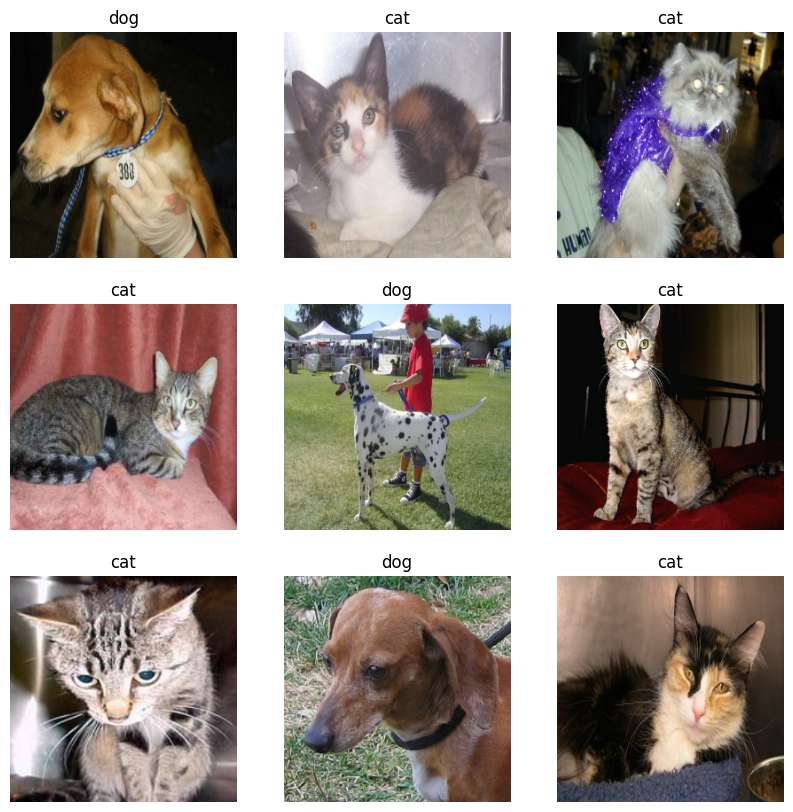

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

The following model applies transfer learning with MobileNet, with input size 224x224. Note that input value normalization and image resizing are performed in the first two layers of the Keras model.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import mobilenet

keras.utils.set_random_seed(42)
IMG_WIDTH, IMG_HEIGHT = 224, 224  # Mobilenet input size

base_model = mobilenet.MobileNet(
    weights="imagenet", include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False
model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(256, 256, 3)),
    layers.Resizing(IMG_HEIGHT, IMG_WIDTH),
    base_model,
    layers.Flatten(),
    layers.Dense(1024, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

The model is compiled and trained next.

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="adam", metrics=["acc"])
history = model.fit(train_ds, validation_data=val_ds,
                    epochs=10, verbose=2)

Epoch 1/10
1/1 - 3s - loss: 1.2874 - acc: 0.5714 - val_loss: 89.3322 - val_acc: 0.5833 - 3s/epoch - 3s/step
Epoch 2/10
1/1 - 0s - loss: 76.4137 - acc: 0.4643 - val_loss: 2.7867 - val_acc: 0.9167 - 189ms/epoch - 189ms/step
Epoch 3/10
1/1 - 0s - loss: 4.6760e-21 - acc: 1.0000 - val_loss: 6.9219 - val_acc: 0.8333 - 192ms/epoch - 192ms/step
Epoch 4/10
1/1 - 0s - loss: 7.8340e-34 - acc: 1.0000 - val_loss: 31.3274 - val_acc: 0.5000 - 178ms/epoch - 178ms/step
Epoch 5/10
1/1 - 0s - loss: 0.7304 - acc: 0.9643 - val_loss: 45.9658 - val_acc: 0.4167 - 180ms/epoch - 180ms/step
Epoch 6/10
1/1 - 0s - loss: 2.4603e-20 - acc: 1.0000 - val_loss: 58.5334 - val_acc: 0.4167 - 172ms/epoch - 172ms/step
Epoch 7/10
1/1 - 0s - loss: 4.7118e-24 - acc: 1.0000 - val_loss: 68.6640 - val_acc: 0.4167 - 193ms/epoch - 193ms/step
Epoch 8/10
1/1 - 0s - loss: 2.5031e-16 - acc: 1.0000 - val_loss: 77.1958 - val_acc: 0.4167 - 189ms/epoch - 189ms/step
Epoch 9/10
1/1 - 0s - loss: 7.5707e-09 - acc: 1.0000 - val_loss: 84.5410 - 

The training history is shown below. The validation accuracy is very poor, about 0.4. The graphs indicate severe overfitting of the model.

{'loss': 0.0235, 'acc': 1.0, 'val_loss': 87.3821, 'val_acc': 0.4167}


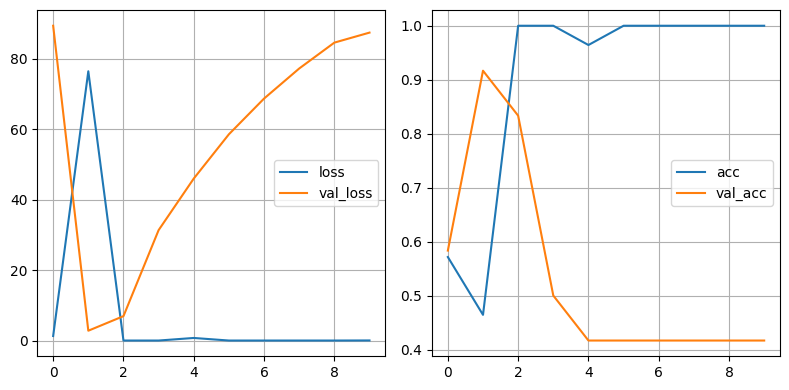

In [ ]:
print(history_final_values(history))
plot_history(history)

Let's use the model to do perform predictions anyway. The predicted results are probability values, and we use the threshold 0.5 to turn them into either 0 or 1.

In [ ]:
import numpy as np
y_probs = model.predict(val_ds)
print(y_probs)
y_pred = np.where(y_probs.ravel() < 0.5, 0, 1)
print(y_pred)

1/1 [==============================] - 1s 521ms/step
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[0 0 0 0 0 0 0 0 0 0 0 0]


The predicted labels, actual labels, and corresponding images are shown below.

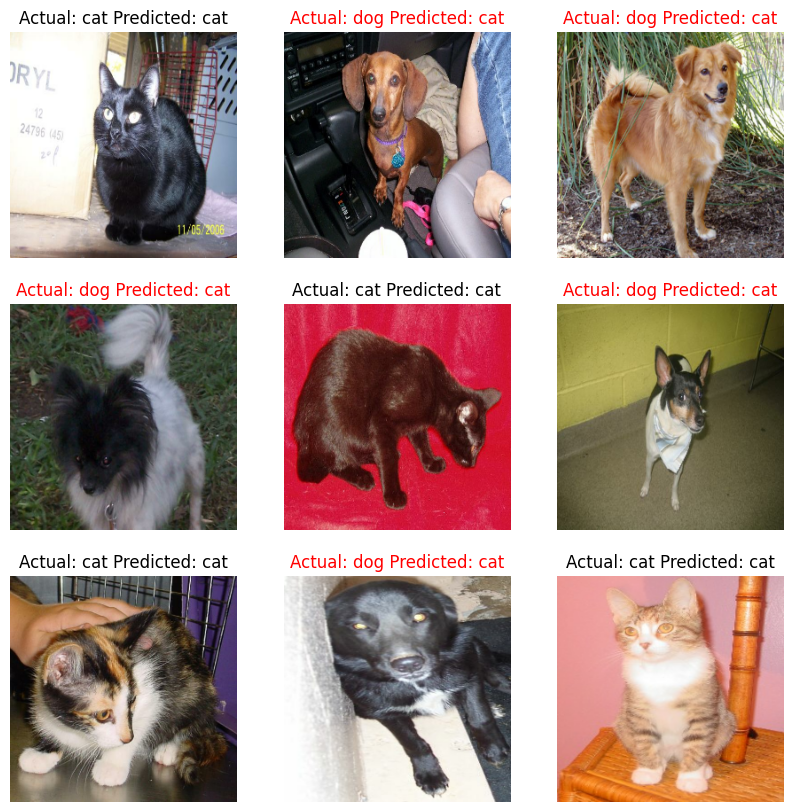

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        title = "Actual: " + val_ds.class_names[labels[i]] + \
            " Predicted: " + val_ds.class_names[y_pred[i]]
        plt.title(title, color="k" if labels[i] == y_pred[i] else "r")
        plt.axis("off")

The main reason for the poor results and overfitting is the very small size of the dataset -- 40 images in total. There are different ways of avoiding overfitting. One way is data augmentation, which we do below.

# Practice - Question 2 of 2

Data augmentation modifies the training examples slightly to obtain more examples with limited variations. It works particularly well when very few training examples are available.

Keras supplies layers that perform data augmentation, e.g. `RandomFlip` for flipping images and `RandomRotation` for rotating images.

## Q2a

Modify the above Keras model for classifying cats and dogs as follows:

- Create a "model" called `data_augmentation` that contains two layers of data augmentation (use code below), and
- Insert `data_augmentation` into the Keras model between the resizing layer and the `base_model`.

```python
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])
```

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import mobilenet

keras.utils.set_random_seed(42)
IMG_WIDTH, IMG_HEIGHT = 224, 224  # Mobilenet input size

base_model = mobilenet.MobileNet(
    weights="imagenet", include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False

# Create data augmentation model
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

# Insert data augmentation into the Keras model
model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(256, 256, 3)),
    layers.Resizing(IMG_HEIGHT, IMG_WIDTH),
    data_augmentation,  # Insert data augmentation here
    base_model,
    layers.Flatten(),
    layers.Dense(1024, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

## Q2b

Compile and train the model. Plot the training history.

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="adam", metrics=["acc"])

In [ ]:
history = model.fit(train_ds, validation_data=val_ds,
                    epochs=10, verbose=2)

Epoch 1/10
1/1 - 4s - loss: 0.8312 - acc: 0.6429 - val_loss: 24.8362 - val_acc: 0.5833 - 4s/epoch - 4s/step
Epoch 2/10
1/1 - 0s - loss: 16.8030 - acc: 0.6429 - val_loss: 24.7546 - val_acc: 0.5000 - 196ms/epoch - 196ms/step
Epoch 3/10
1/1 - 0s - loss: 15.3027 - acc: 0.8214 - val_loss: 23.7225 - val_acc: 0.6667 - 182ms/epoch - 182ms/step
Epoch 4/10
1/1 - 0s - loss: 6.2671 - acc: 0.7857 - val_loss: 4.3952 - val_acc: 0.9167 - 175ms/epoch - 175ms/step
Epoch 5/10
1/1 - 0s - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.1363 - val_acc: 0.9167 - 173ms/epoch - 173ms/step
Epoch 6/10
1/1 - 0s - loss: 1.5132e-27 - acc: 1.0000 - val_loss: 5.4538 - val_acc: 0.9167 - 189ms/epoch - 189ms/step
Epoch 7/10
1/1 - 0s - loss: 8.4242e-14 - acc: 1.0000 - val_loss: 11.6806 - val_acc: 0.8333 - 193ms/epoch - 193ms/step
Epoch 8/10
1/1 - 0s - loss: 1.2633 - acc: 0.9643 - val_loss: 15.3080 - val_acc: 0.8333 - 193ms/epoch - 193ms/step
Epoch 9/10
1/1 - 0s - loss: 5.0304e-31 - acc: 1.0000 - val_loss: 18.3841 - val_acc:

{'loss': 2.4536, 'acc': 0.9643, 'val_loss': 17.4268, 'val_acc': 0.8333}


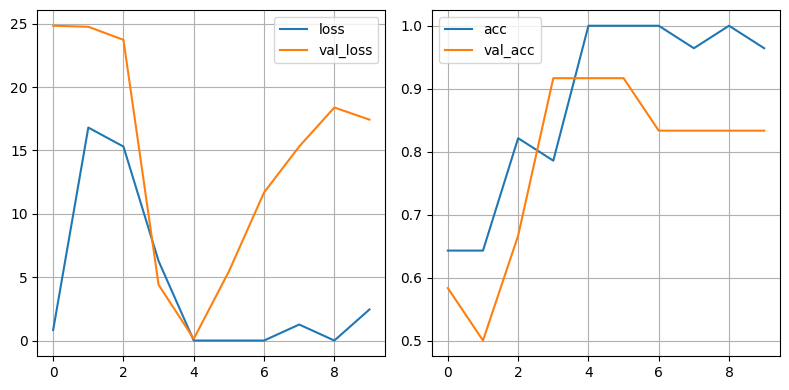

In [ ]:
print(history_final_values(history))
plot_history(history)

In [ ]:
import numpy as np
y_probs = model.predict(val_ds)
print(y_probs)
y_pred = np.where(y_probs.ravel() < 0.5, 0, 1)
print(y_pred)

1/1 [==============================] - 1s 517ms/step
[[0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]]
[0 1 1 1 1 1 0 1 0 1 1 1]


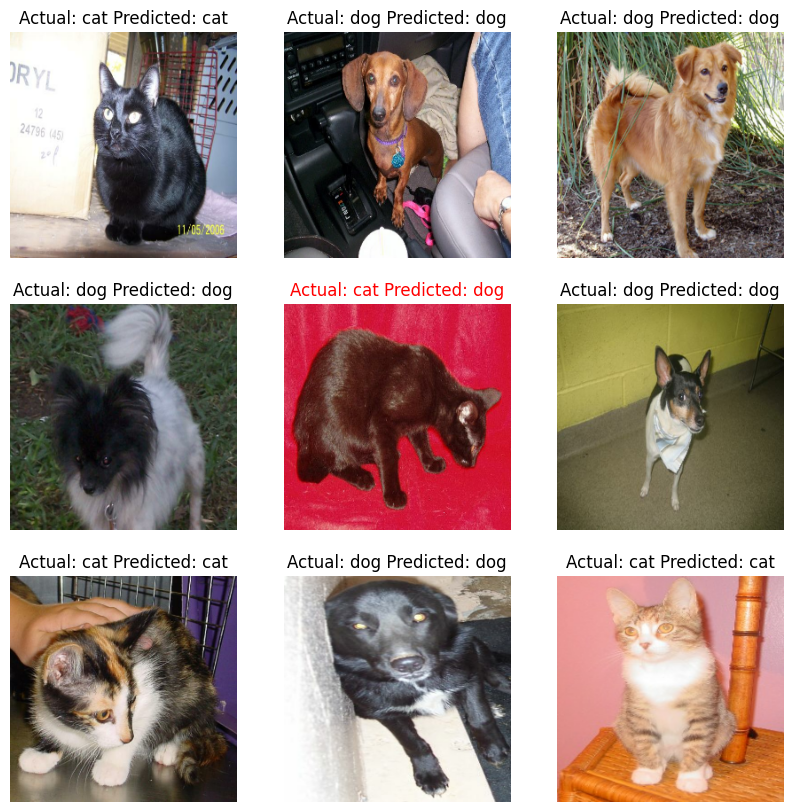

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        title = "Actual: " + val_ds.class_names[labels[i]] + \
            " Predicted: " + val_ds.class_names[y_pred[i]]
        plt.title(title, color="k" if labels[i] == y_pred[i] else "r")
        plt.axis("off")

With data augmentation, the validation results are improved.

## &#x2766;

The improved model can be used to perform predictions as shown below.

In [ ]:
import numpy as np
y_probs = model.predict(val_ds)
print(y_probs)
y_pred = np.where(y_probs.ravel() < 0.5, 0, 1)
print(y_pred)

1/1 [==============================] - 0s 78ms/step
[[0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]]
[0 1 1 1 1 1 0 1 0 1 1 1]


These are some predicted labels, actual labels, and corresponding images.

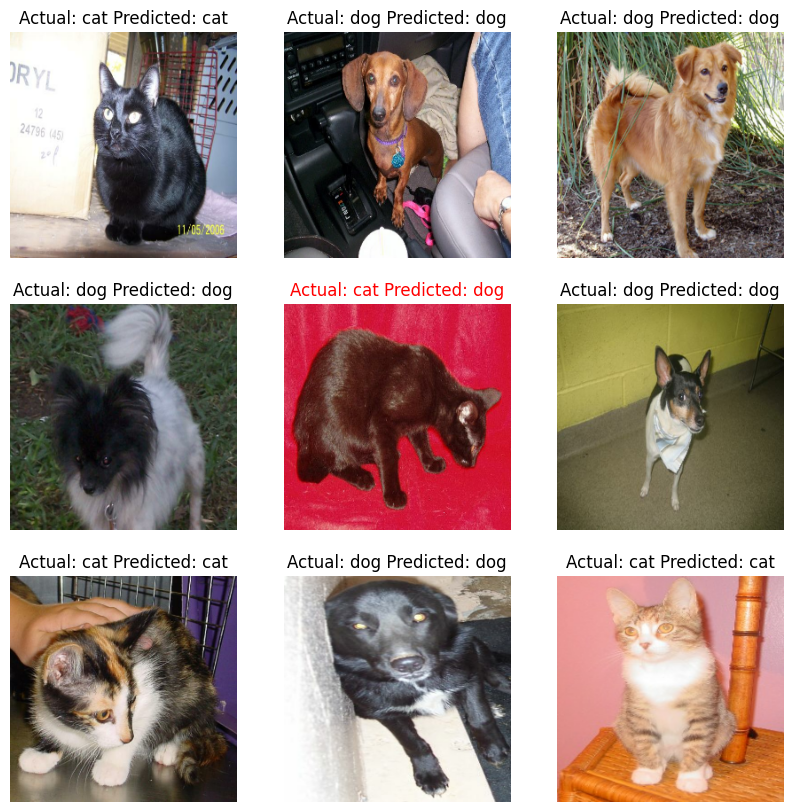

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        title = "Actual: " + val_ds.class_names[labels[i]] + \
            " Predicted: " + val_ds.class_names[y_pred[i]]
        plt.title(title, color="k" if labels[i] == y_pred[i] else "r")
        plt.axis("off")

# Extras

## Transfer learning with VGG-16

The following model reuses the VGG-16 pre-trained model for classifying the CIFAR-10 dataset. Note the calls to the `vgg16.preprocess_input()` function, the input shape of 32&times;32&times;3 specified in the `VGG16` model creation, and the setting of the `VGG16` model to be not trainable.

In [ ]:
from tensorflow.keras.applications import vgg16

X_train, y_train, X_test, y_test = load_and_prep_cifar10_no_scale_x()
X_train = vgg16.preprocess_input(X_train)
X_test = vgg16.preprocess_input(X_test)
base_model = vgg16.VGG16(weights="imagenet", include_top=False,
                         input_shape=(32, 32, 3))
base_model.trainable = False
model = keras.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(1024, activation="relu"),
    layers.Dense(10, activation="softmax")
])
history = compile_and_fit_model(model, X_train, y_train, X_test, y_test)

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/20
98/98 - 7s - loss: 3.4414 - acc: 0.5425 - val_loss: 2.0045 - val_acc: 0.5900 - 7s/epoch - 67ms/step
Epoch 2/20
98/98 - 4s - loss: 1.1069 - acc: 0.6952 - val_loss: 1.7169 - val_acc: 0.6102 - 4s/epoch - 38ms/step
Epoch 3/20
98/98 - 4s - loss: 0.6150 - acc: 0.7994 - val_loss: 1.6219 - val_acc: 0.6148 - 4s/epoch - 39ms/step
Epoch 4/20
98/98 - 4s - loss: 0.3496 - acc: 0.8794 - val_loss: 1.6109 - val_acc: 0.6252 - 4s/epoch - 38ms/step
Epoch 5/20
98/98 - 4s - loss: 0.2102 - acc: 0.9334 - val_loss: 1.6527 - val_acc: 0.6348 - 4s/epoch - 38ms/step
Epoch 6/20
98/98 - 4s - loss: 0.1287 - acc: 0.9675 - val_loss: 1.6861 - val_acc: 0.6376 - 4s/epoch - 39ms/step
Epoch 7/20
98/98 - 4s - loss: 0.0755 - acc: 0.9869 - val_loss: 1.7348 - val_acc: 0.6450 - 4s/epoch - 38ms/step
Epoch 8/20
98/98 - 4s - loss: 0.0502 - acc: 0.9945 - val_loss: 1.7924 - val_acc: 0.6444 - 4s/epoch - 38ms/step
Epoch 9/20
98/98 - 4s - loss: 0.0414 - acc: 0.9

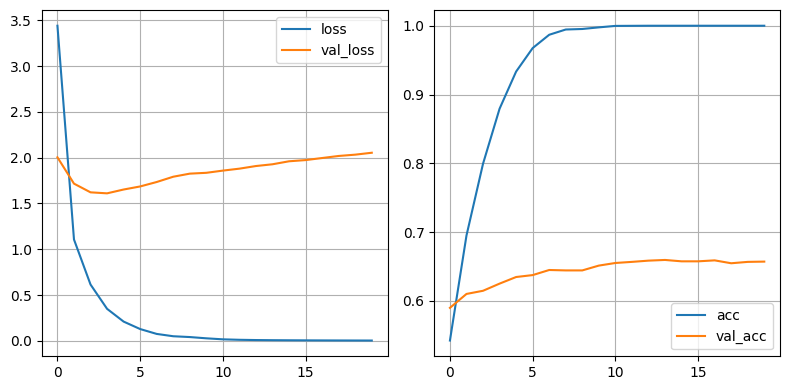

In [ ]:
plot_history(history)

The training is relatively fast, and the validation results are good. However, the curve of the validation loss indicates overfitting.

## Simplifying pre-trained models

In this section, we attempt to mitigate overfitting by simplifying the VGG-16 pre-trained model. Customizing the structure of a pre-trained model is not a frequently-used technique, and may not be applicable to some pre-trained models. Anyway, we adopt this technique to learn about the structure of the VGG-16 model and how model simplicity reduces overfitting.

The summary of the VGG-16 model is shown below. The model contains 5 VGG blocks, where each VGG block contains 2 or 3 convolutional layers followed by 1 max-pooling layer.

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

One way to simplify the structure of the VGG-16 model is discarding one or two final VGG blocks (i.e. near the output layer, or near the "top").

## E1a

Modify the above provided VGG-16 transfer learning model to discard the final 4 layers (i.e. 1 VGG block) in the VGG-16 pre-trained model. Specifically, modify the `model` creation to set the first layer to

```python
keras.Sequential(base_model.layers[:-4])
```

instead of `base_model`.

## E1b

You should find the model in E1a (i.e. with the final 4 layers discarded) having better validation results. Discuss some possible reasons for the improved performance.

(Hint: Consider the relation between model complexity and overfitting, and the kind of patterns/knowledge learned in different convolutional layers in a model.)

## E1c

Modify the above provided VGG-16 transfer learning model to discard the final 8 layers (i.e. 2 VGG blocks) in the VGG-16 pre-trained model. Specifically, modify the `model` creation to set the first layer to

```python
keras.Sequential(base_model.layers[:-8])
```

instead of `base_model`.

## E1d

You should find the model in E1c (i.e. with the final 8 layers discarded) having poor validation results. Discuss one or more possible reasons for the poor performance.

## Solutions to extra exercises

### E1a

In [ ]:
# Solution

from tensorflow.keras.applications import vgg16

X_train, y_train, X_test, y_test = load_and_prep_cifar10_no_scale_x()
X_train = vgg16.preprocess_input(X_train)
X_test = vgg16.preprocess_input(X_test)
base_model = vgg16.VGG16(weights="imagenet", include_top=False,
                         input_shape=(32, 32, 3))
base_model.trainable = False
base_model_trimmed = keras.Sequential(base_model.layers[:-4])
model = keras.Sequential([
    base_model_trimmed,
    layers.Flatten(),
    layers.Dense(1024, activation="relu"),
    layers.Dense(10, activation="softmax")
])
history = compile_and_fit_model(model, X_train, y_train, X_test, y_test)

Epoch 1/20
98/98 - 5s - loss: 116.4352 - acc: 0.4601 - val_loss: 2.4631 - val_acc: 0.3584 - 5s/epoch - 53ms/step
Epoch 2/20
98/98 - 3s - loss: 2.0261 - acc: 0.3910 - val_loss: 1.9961 - val_acc: 0.4354 - 3s/epoch - 35ms/step
Epoch 3/20
98/98 - 3s - loss: 1.5710 - acc: 0.4930 - val_loss: 1.7270 - val_acc: 0.4940 - 3s/epoch - 35ms/step
Epoch 4/20
98/98 - 3s - loss: 1.2719 - acc: 0.5632 - val_loss: 1.5639 - val_acc: 0.5570 - 3s/epoch - 34ms/step
Epoch 5/20
98/98 - 3s - loss: 1.0996 - acc: 0.6130 - val_loss: 1.5248 - val_acc: 0.5800 - 3s/epoch - 34ms/step
Epoch 6/20
98/98 - 3s - loss: 0.9850 - acc: 0.6574 - val_loss: 1.4618 - val_acc: 0.6118 - 3s/epoch - 35ms/step
Epoch 7/20
98/98 - 3s - loss: 0.8969 - acc: 0.6837 - val_loss: 1.3920 - val_acc: 0.6236 - 3s/epoch - 34ms/step
Epoch 8/20
98/98 - 3s - loss: 0.8106 - acc: 0.7126 - val_loss: 1.3251 - val_acc: 0.6474 - 3s/epoch - 35ms/step
Epoch 9/20
98/98 - 3s - loss: 0.7404 - acc: 0.7316 - val_loss: 1.3931 - val_acc: 0.6578 - 3s/epoch - 35ms/step

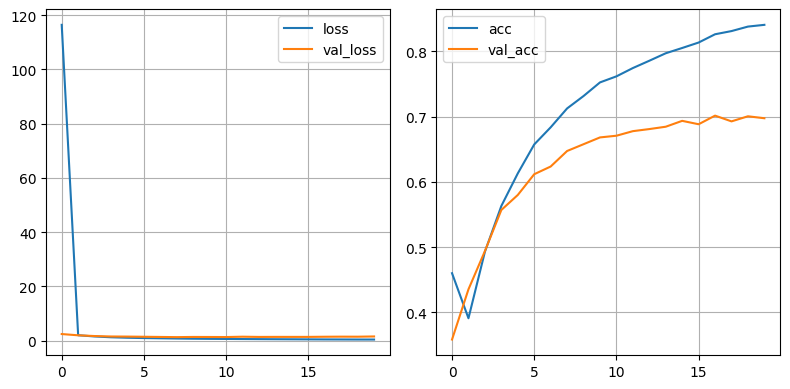

In [ ]:
# Solution

plot_history(history)

### E1b

Solution:

Discarding some layers reduces the complexity of a model, which in turns reduces the overfitting problem that occurs when the whole VGG-16 pre-trained model is incorporated.

In a CNN, initial convolutional layers detect low-level generic features such as lines and simple shapes, while final convolutional layers detect high-level task-specific features. Discarding some final layers reduces the knowledge specific to the original task of the pre-trained model; such knowledge is not useful for, and may even worsen, our new model for the current task. Reducing such knowledge helps improving our new model.

### E1c

In [ ]:
# Solution

from tensorflow.keras.applications import vgg16

X_train, y_train, X_test, y_test = load_and_prep_cifar10_no_scale_x()
X_train = vgg16.preprocess_input(X_train)
X_test = vgg16.preprocess_input(X_test)
base_model = vgg16.VGG16(weights="imagenet", include_top=False,
                         input_shape=(32, 32, 3))
base_model.trainable = False
base_model_trimmed = keras.Sequential(base_model.layers[:-8])
model = keras.Sequential([
    base_model_trimmed,
    layers.Flatten(),
    layers.Dense(1024, activation="relu"),
    layers.Dense(10, activation="softmax")
])
history = compile_and_fit_model(model, X_train, y_train, X_test, y_test)

Epoch 1/20
98/98 - 4s - loss: 1593.5740 - acc: 0.2488 - val_loss: 2.5994 - val_acc: 0.1304 - 4s/epoch - 40ms/step
Epoch 2/20
98/98 - 2s - loss: 2.3892 - acc: 0.1254 - val_loss: 2.3742 - val_acc: 0.1194 - 2s/epoch - 24ms/step
Epoch 3/20
98/98 - 2s - loss: 2.2959 - acc: 0.1286 - val_loss: 2.3411 - val_acc: 0.1228 - 2s/epoch - 22ms/step
Epoch 4/20
98/98 - 2s - loss: 2.2668 - acc: 0.1335 - val_loss: 2.3321 - val_acc: 0.1330 - 2s/epoch - 21ms/step
Epoch 5/20
98/98 - 2s - loss: 2.2459 - acc: 0.1372 - val_loss: 2.3319 - val_acc: 0.1398 - 2s/epoch - 21ms/step
Epoch 6/20
98/98 - 2s - loss: 2.2336 - acc: 0.1406 - val_loss: 2.3025 - val_acc: 0.1312 - 2s/epoch - 21ms/step
Epoch 7/20
98/98 - 2s - loss: 2.2168 - acc: 0.1514 - val_loss: 2.3052 - val_acc: 0.1314 - 2s/epoch - 24ms/step
Epoch 8/20
98/98 - 2s - loss: 2.1995 - acc: 0.1539 - val_loss: 2.2950 - val_acc: 0.1616 - 2s/epoch - 24ms/step
Epoch 9/20
98/98 - 2s - loss: 2.1728 - acc: 0.1668 - val_loss: 2.3659 - val_acc: 0.1820 - 2s/epoch - 22ms/ste

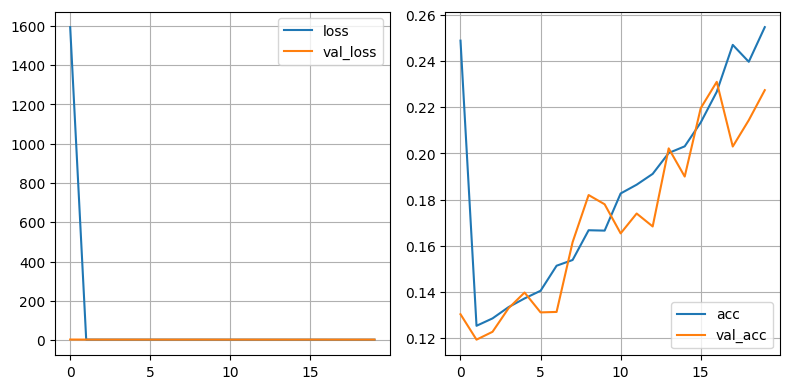

In [ ]:
# Solution

plot_history(history)

### E1d

Solution:

While discarding some layers generally helps reducing overfitting, discarding 8 layers is probably too much for the task in question. Some of the discarded layers may be required for detecting the patterns in the CIFAR-10 dataset, so discarding them makes the pre-trained model less capable. In fact, the execution outputs show poor results in both training and validation, which indicates underfitting in the model.

## &#x2766;